In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

dataset = pd.read_csv('/content/drive/MyDrive/breast-cancer.csv', index_col=False)
dataset.head()
# replacing values
dataset['diagnosis'].replace(['B', 'M'],
                        [0, 1], inplace=True)
x = dataset.iloc[:,2:]
y = dataset.iloc[:,1]
x_train , x_test , y_train , y_test = train_test_split(np.array(x), np.array(y), random_state=50, test_size = 0.25)

Overfitting refers to the condition when the model completely fits the training data but fails to generalize the testing unseen data. 

Overfit condition arises when the model memorizes the noise of the training data and fails to capture important patterns. 

A perfectly fit decision tree performs well for training data but performs poorly for unseen test data.

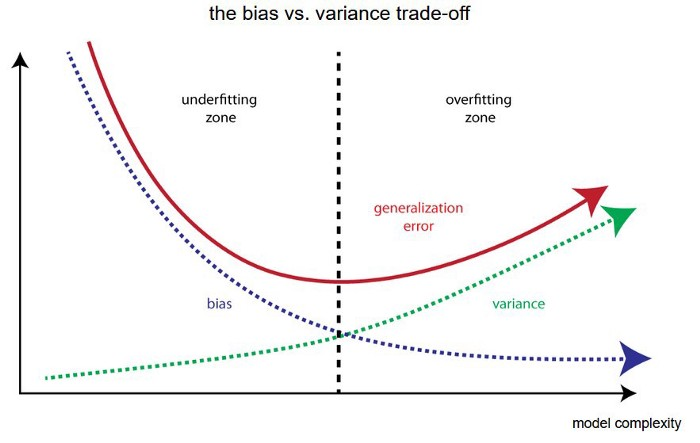

Techniques for avoiding overfitting:
Pruning
* Pre-pruning
* Post-pruning
* Ensemble - Random Forest

By default, the decision tree model is allowed to grow to its full depth. 

Pruning refers to a technique to remove the parts of the decision tree to prevent growing to its full depth. 

By tuning the hyperparameters of the decision tree model one can prune the trees and prevent them from overfitting.
There are two types of pruning Pre-pruning and Post-pruning.

Pre-Pruning

The pre-pruning technique refers to the early stopping of the growth of the decision tree. 

The pre-pruning technique involves tuning the hyperparameters of the decision tree model prior to the training pipeline. 

The hyperparameters of the decision tree including max_depth, min_samples_leaf, min_samples_split can be tuned to early stop the growth of the tree and prevent the model from overfitting.

* min_samples_split specifies the minimum number of samples required to split an internal node, 
* while min_samples_leaf specifies the minimum number of samples required to be at a leaf node.

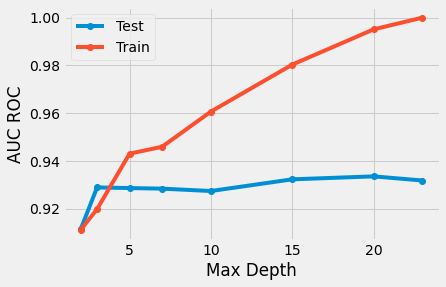


* The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. 
* The true-positive rate is also known as sensitivity, recall or probability of detection.
* The false-positive rate is also known as probability of false alarm[9] and can be calculated as (1 − specificity).

use the sklearn implementation of the GridSearchCV technique to find the best set of hyperparameters for a decision tree model.

AUC_ROC

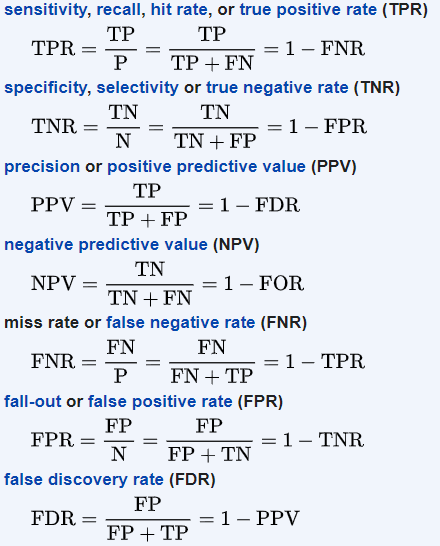

In [3]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score

param_grid = {
    "max_depth": [3, 5, 10, 15, 20, None],
    "min_samples_split": [2, 5, 7, 10],
    "min_samples_leaf": [1, 2, 5]
}

clf = DecisionTreeClassifier(random_state=42)

from sklearn.impute import SimpleImputer
import numpy as np

# Create an instance of the SimpleImputer class with the mean strategy
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on x_train and transform x_train
x_train_imputed = imputer.fit_transform(x_train)

# Check for non-finite values in x_train_imputed
mask = np.isfinite(x_train_imputed).all(axis=1)
x_train_imputed = x_train_imputed[mask]
y_train = y_train[mask]

# Now you can use x_train_imputed and y_train without non-finite values
grid_cv = GridSearchCV(clf, param_grid, scoring="roc_auc", n_jobs=-1, cv=3, error_score='raise').fit(x_train_imputed, y_train)

# Perform the same preprocessing on x_test
x_test_imputed = imputer.transform(x_test)
mask_test = np.isfinite(x_test_imputed).all(axis=1)
x_test_imputed = x_test_imputed[mask_test]
y_test = y_test[mask_test]

print("Param for GS:", grid_cv.best_params_)
print("CV score for GS:", grid_cv.best_score_)
print("Train AUC ROC Score for GS:", roc_auc_score(y_train, grid_cv.predict(x_train_imputed)))
print("Test AUC ROC Score for GS:", roc_auc_score(y_test, grid_cv.predict(x_test_imputed)))


Param for GS: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 2}
CV score for GS: 0.959437495583351
Train AUC ROC Score for GS: 0.9716981132075472
Test AUC ROC Score for GS: 0.9550314465408805


Post-Pruning:
* The Post-pruning technique allows the decision tree model to grow to its full depth, then removes the tree branches to prevent the model from overfitting. 

* Cost complexity pruning (ccp) is one type of post-pruning technique. In case of cost complexity pruning, the ccp_alpha can be tuned to get the best fit model.

Steps for cost complexity pruning (post-pruning) are:

* Train a decision tree classifier to its full depth (default hyperparameters).

* Compute the ccp_alphas value using function cost_complexity_pruning_path().

* Train decision tree classifiers with different values of ccp_alphas and compute train and test performance scores.

* Plot train and test scores for each value of ccp_alphas values.

In [4]:
from sklearn.impute import SimpleImputer

# Create an instance of the SimpleImputer class with the mean strategy
imputer = SimpleImputer(strategy='mean')

# Fit the imputer on x_train and transform x_train
x_train_imputed = imputer.fit_transform(x_train)

# Transform x_test using the fitted imputer
x_test_imputed = imputer.transform(x_test)

# Now you can use x_train_imputed and x_test_imputed to fit and predict with the model
clf = DecisionTreeClassifier(random_state=42)
clf.fit(x_train_imputed, y_train)
print("Train AUC ROC Score: ", roc_auc_score(y_train, clf.predict(x_train_imputed)))
print("Test AUC ROC Score: ", roc_auc_score(y_test, clf.predict(x_test_imputed)))


Train AUC ROC Score:  1.0
Test AUC ROC Score:  0.9255765199161425


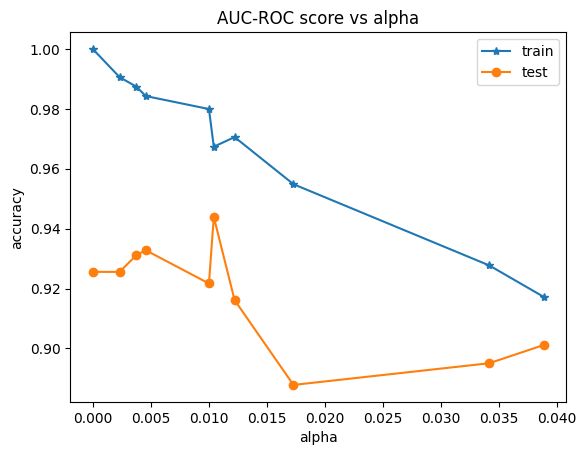

In [5]:
from sklearn.impute import SimpleImputer

# Create an imputer and fit it on the training data
imputer = SimpleImputer()
x_train_imputed = imputer.fit_transform(x_train)
x_test_imputed = imputer.transform(x_test)  # Impute missing values in the test data

# Compute ccp_alpha values
path = clf.cost_complexity_pruning_path(x_train_imputed, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Train DT classifier for each ccp_alpha value
clfs = []
for ccp_alpha in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    clf.fit(x_train_imputed, y_train)
    clfs.append(clf)

# Plot train and test score for each of the above trained models
clfs = clfs[:-1]
ccp_alphas = ccp_alphas[:-1]

train_scores = [roc_auc_score(y_train, clf.predict(x_train_imputed)) for clf in clfs]
test_scores = [roc_auc_score(y_test, clf.predict(x_test_imputed)) for clf in clfs]

fig, ax = plt.subplots()
ax.set_xlabel("alpha")
ax.set_ylabel("accuracy")
ax.set_title("AUC-ROC score vs alpha")
ax.plot(ccp_alphas, train_scores, marker='*', label="train")
ax.plot(ccp_alphas, test_scores, marker='o', label="test")
ax.legend()
plt.show()

Ensemble — Random Forest:
* Random Forest is an ensemble technique for classification and regression by bootstrapping multiple decision trees. 

* Random Forest follows bootstrap sampling and aggregation techniques to prevent overfitting.